In [1]:
from flytekit.sdk.types import Types
from flytekit.common import utils
from flytekit.common.workflow_execution import SdkWorkflowExecution

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
wf = SdkWorkflowExecution.fetch(project="flytekubecondemo2019", domain="development", name="gt1785aotr")


In [3]:
print(wf.outputs)

{'ground_truths': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [4]:
from __future__ import absolute_import
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as _cm
from sklearn.utils.multiclass import unique_labels

from flytekit.sdk.tasks import (
    python_task,
    inputs,
    outputs,
)
from flytekit.sdk.types import Types
from flytekit.common import utils

import numpy as np


def _plot_confusion_matrix(y_true, y_pred, classes, to_file_path=None, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix to a file, if given or shows. It also returns the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = _cm(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    if to_file_path is None:
        plt.show()
    else:
        plt.savefig(to_file_path)
    return cm


@inputs(y_true=[Types.Integer], y_pred=[Types.Integer], title=Types.String, normalize=Types.Boolean, classes=[Types.String])
@outputs(matrix=[[Types.Integer]], visual=Types.Blob)
@python_task
def confusion_matrix(wf_params, y_true, y_pred, title, normalize, classes, matrix, visual):
    with utils.AutoDeletingTempDir('test') as tmpdir:
        f_path = tmpdir.get_named_tempfile("visual")
        cm = _plot_confusion_matrix(np.asarray(y_true), np.asarray(y_pred), classes=np.asarray(classes), title=title, normalize=normalize, to_file_path=f_path)
        visual.set(f_path)
        m = []
        for i in range(cm.shape[0]):
            m.append([])
            for j in range(cm.shape[1]):
              m[i].append(j)
        matrix.set(m)


Normalized confusion matrix


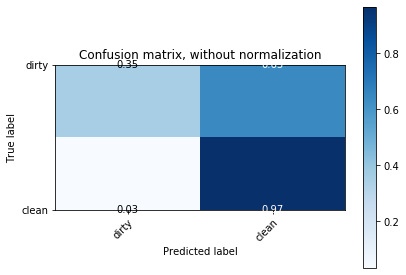

In [6]:
cm = confusion_matrix.unit_test(y_true=wf.outputs["ground_truths"], y_pred=wf.outputs["predictions"], title='Confusion matrix, wih normalization', normalize=True, classes=["dirty", "clean"])

In [21]:
import numpy as np
from sklearn import metrics
y = np.array([0, 0, 1, 1])
scores = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)
print(fpr)
print(tpr)
print(thresholds)

def cutoff_youdens_j(fpr,tpr,thresholds):
    j_scores = tpr-fpr
    j_ordered = sorted(zip(j_scores,thresholds))
    print(j_ordered)
    return j_ordered[-1][1]

print(cutoff_youdens_j(fpr, tpr, thresholds))

[0.  0.  0.5 0.5 1. ]
[0.  0.5 0.5 1.  1. ]
[1.8  0.8  0.4  0.35 0.1 ]
[(0.0, 0.1), (0.0, 0.4), (0.0, 1.8), (0.5, 0.35), (0.5, 0.8)]
0.8


In [7]:
print(cm)

{'matrix': [[0, 1], [0, 1]], 'visual': metadata {
  type {
  }
}
uri: "/var/folders/lh/1lwrhs7j7xj69b4hdr3k1d800000gp/T/test_kg6lctio/visual"
}
